In [12]:
#Import the libraries
import warnings
warnings.filterwarnings('ignore')

import os
import math
import numpy as np
import pandas as pd 
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.dates as mpdates


import datetime
from dateutil.parser import parse
from sklearn.preprocessing import MinMaxScaler
from mplfinance.original_flavor import candlestick_ohlc

import keras
import tensorflow as tf
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dropout, Dense
from tensorflow.keras.callbacks import EarlyStopping

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

import pmdarima as pm
from pmdarima.arima.utils import ndiffs

from prophet import Prophet
from prophet.plot import plot_plotly

In [13]:
import pandas as pd

# Load the data
df_aapl = pd.read_csv('data/AAPL.csv')
df_adbe = pd.read_csv('data/ADBE.csv')
df_amd = pd.read_csv('data/AMD.csv')
df_cmcsa = pd.read_csv('data/CMCSA.csv')
df_cost = pd.read_csv('data/COST.csv')
df_intc = pd.read_csv('data/INTC.csv')
df_intu = pd.read_csv('data/INTU.csv')
df_msft = pd.read_csv('data/MSFT.csv')
df_qcom = pd.read_csv('data/QCOM.csv')
df_sbux = pd.read_csv('data/SBUX.csv')

dfs = [df_aapl, df_adbe, df_amd, df_cmcsa, df_cost, df_intc, df_intu, df_msft, df_qcom, df_sbux]

for df in dfs:
    df['Date'] = pd.to_datetime(df['Date'], format='%d-%m-%Y')
    df.set_index('Date', inplace=True)
    df.sort_index(inplace=True)

In [14]:
def remove_before_2005(df):
    df = df[df.index.year >= 2005]
    df.reset_index(inplace=True)
    return df

dfs = [remove_before_2005(df) for df in dfs]

df_aapl, df_adbe, df_amd, df_cmcsa, df_cost, df_intc, df_intu, df_msft, df_qcom, df_sbux = dfs

In [15]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

def retrieve_closing_prices_only(data):
    return data[['Close']]

def min_max_scaling(data):
    scaler = MinMaxScaler(feature_range=(0, 1))
    normalized_data = scaler.fit_transform(data.values)
    return scaler, pd.DataFrame(normalized_data, columns=['Close'])

In [16]:

aapl_scaler, new_aapl_df = min_max_scaling(retrieve_closing_prices_only(df_aapl))
adbe_scaler, new_adbe_df = min_max_scaling(retrieve_closing_prices_only(df_adbe))
amd_scaler, new_amd_df = min_max_scaling(retrieve_closing_prices_only(df_amd))
cmcsa_scaler, new_cmcsa_df = min_max_scaling(retrieve_closing_prices_only(df_cmcsa))
cost_scaler, new_cost_df = min_max_scaling(retrieve_closing_prices_only(df_cost))
intc_scaler, new_intc_df = min_max_scaling(retrieve_closing_prices_only(df_intc))
intu_scaler, new_intu_df = min_max_scaling(retrieve_closing_prices_only(df_intu))
msft_scaler, new_msft_df = min_max_scaling(retrieve_closing_prices_only(df_msft))
qcom_scaler, new_qcom_df = min_max_scaling(retrieve_closing_prices_only(df_qcom))
sbux_scaler, new_sbux_df = min_max_scaling(retrieve_closing_prices_only(df_sbux))

In [17]:
new_aapl_df.head()

,Close
0,0.000000
1,0.000064
2,0.000119
3,0.000124
4,0.000588


In [18]:
import numpy as np

def split_and_reshape_data(dataframe, pred_days, company):
    prediction_days = pred_days
    
    train_size = int(np.ceil(len(dataframe) * 0.90))
    test_size = int(np.ceil(len(dataframe) * 0.10))
    
    print(f'The training size for {company.title()} is {train_size} rows')
    print(f'The testing size for {company.title()} is {test_size} rows')
    
    data_array = dataframe['Close'].values
    
    train_data = data_array[0: train_size]
    test_data = data_array[train_size - prediction_days: train_size + test_size]
    
    X_train, y_train, X_test, y_test = [], [], [], []
    
    for i in range(prediction_days, len(train_data)):
        X_train.append(train_data[i - prediction_days: i])
        y_train.append(train_data[i])
        
    for i in range(prediction_days, len(test_data)):
        X_test.append(test_data[i - prediction_days: i])
        y_test.append(test_data[i])
          
    X_train, y_train = np.array(X_train), np.array(y_train)
    X_test, y_test = np.array(X_test), np.array(y_test)
    
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
    
    print(f'Data for {company.title()} split successfully')
    
    return X_train, y_train, X_test, y_test

In [19]:
X_train_aapl, y_train_aapl, X_test_aapl, y_test_aapl = split_and_reshape_data(new_aapl_df, 30, 'Apple')
X_train_adbe, y_train_adbe, X_test_adbe, y_test_adbe = split_and_reshape_data(new_adbe_df, 30, 'Adobe')
X_train_amd, y_train_amd, X_test_amd, y_test_amd = split_and_reshape_data(new_amd_df, 30, 'AMD')
X_train_cmcsa, y_train_cmcsa, X_test_cmcsa, y_test_cmcsa = split_and_reshape_data(new_cmcsa_df, 30, 'Comcast')
X_train_cost, y_train_cost, X_test_cost, y_test_cost = split_and_reshape_data(new_cost_df, 30, 'Costco')
X_train_intc, y_train_intc, X_test_intc, y_test_intc = split_and_reshape_data(new_intc_df, 30, 'Intel')
X_train_intu, y_train_intu, X_test_intu, y_test_intu = split_and_reshape_data(new_intu_df, 30, 'Intuit')
X_train_msft, y_train_msft, X_test_msft, y_test_msft = split_and_reshape_data(new_msft_df, 30, 'Microsoft')
X_train_qcom, y_train_qcom, X_test_qcom, y_test_qcom = split_and_reshape_data(new_qcom_df, 30, 'Qualcomm')
X_train_sbux, y_train_sbux, X_test_sbux, y_test_sbux = split_and_reshape_data(new_sbux_df, 30, 'Starbucks')


The training size for Apple is 4067 rows
The testing size for Apple is 452 rows
Data for Apple split successfully
The training size for Adobe is 4067 rows
The testing size for Adobe is 452 rows
Data for Adobe split successfully
The training size for Amd is 4067 rows
The testing size for Amd is 452 rows
Data for Amd split successfully
The training size for Comcast is 4067 rows
The testing size for Comcast is 452 rows
Data for Comcast split successfully
The training size for Costco is 4067 rows
The testing size for Costco is 452 rows
Data for Costco split successfully
The training size for Intel is 4067 rows
The testing size for Intel is 452 rows
Data for Intel split successfully
The training size for Intuit is 4067 rows
The testing size for Intuit is 452 rows
Data for Intuit split successfully
The training size for Microsoft is 4067 rows
The testing size for Microsoft is 452 rows
Data for Microsoft split successfully
The training size for Qualcomm is 4067 rows
The testing size for Qualc

In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import Huber
from tensorflow.keras.callbacks import EarlyStopping

def create_and_train_lstm_model(X_train, y_train, X_test, y_test, company):
    print(f'=========For {company}=========')
    
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
    
    # Define the model
    model = Sequential([
        Conv1D(32, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)),
        LSTM(64, return_sequences=True),
        LSTM(64),
        Dropout(0.2),  # Dropout
        Dense(16, activation='relu'),
        Dropout(0.2),  # Dropout
        Dense(1)
    ])
    
    model.compile(optimizer=Adam(), loss=Huber(), metrics=['mse'])
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=32, callbacks=[early_stopping])
    y_pred = model.predict(X_test)
    
    return model, history, y_pred


=========For Apple=========
Epoch 1/50
127/127 [==============================] - 3s 12ms/step - loss: 0.0020 - mse: 0.0040 - val_loss: 0.0020 - val_mse: 0.0040
Epoch 2/50
127/127 [==============================] - 1s 9ms/step - loss: 8.6599e-04 - mse: 0.0017 - val_loss: 0.0022 - val_mse: 0.0045
Epoch 3/50
127/127 [==============================] - 1s 9ms/step - loss: 8.1180e-04 - mse: 0.0016 - val_loss: 7.6939e-04 - val_mse: 0.0015
Epoch 4/50
127/127 [==============================] - 1s 9ms/step - loss: 7.3535e-04 - mse: 0.0015 - val_loss: 0.0021 - val_mse: 0.0043
Epoch 5/50
127/127 [==============================] - 1s 9ms/step - loss: 6.4948e-04 - mse: 0.0013 - val_loss: 0.0017 - val_mse: 0.0033
Epoch 6/50
15/15 [==============================] - 0s 4ms/step
The MSE for Apple is 0.0015387727473111883


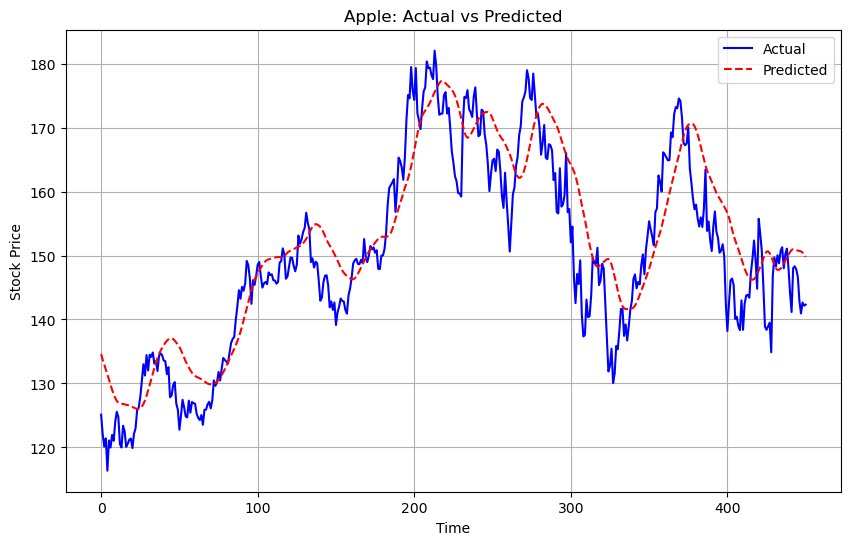

=========For Adobe=========
Epoch 1/50
127/127 [==============================] - 4s 12ms/step - loss: 0.0031 - mse: 0.0062 - val_loss: 0.0026 - val_mse: 0.0052
Epoch 2/50
127/127 [==============================] - 1s 9ms/step - loss: 0.0013 - mse: 0.0025 - val_loss: 0.0015 - val_mse: 0.0029
Epoch 3/50
127/127 [==============================] - 1s 9ms/step - loss: 0.0011 - mse: 0.0021 - val_loss: 0.0024 - val_mse: 0.0048
Epoch 4/50
127/127 [==============================] - 1s 9ms/step - loss: 8.3812e-04 - mse: 0.0017 - val_loss: 0.0012 - val_mse: 0.0023
Epoch 5/50
127/127 [==============================] - 1s 10ms/step - loss: 8.2330e-04 - mse: 0.0016 - val_loss: 0.0072 - val_mse: 0.0144
Epoch 6/50
127/127 [==============================] - 1s 9ms/step - loss: 8.3720e-04 - mse: 0.0017 - val_loss: 0.0025 - val_mse: 0.0049
Epoch 7/50
15/15 [==============================] - 0s 3ms/step
The MSE for Adobe is 0.00232036536381238


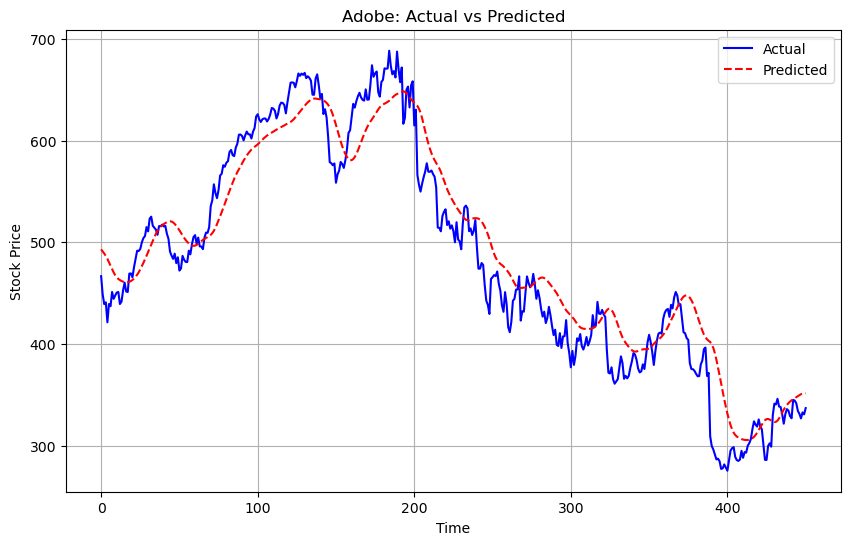

=========For AMD=========
Epoch 1/50
127/127 [==============================] - 3s 11ms/step - loss: 9.5484e-04 - mse: 0.0019 - val_loss: 0.0016 - val_mse: 0.0033
Epoch 2/50
127/127 [==============================] - 1s 9ms/step - loss: 4.6787e-04 - mse: 9.3574e-04 - val_loss: 0.0018 - val_mse: 0.0036
Epoch 3/50
127/127 [==============================] - 1s 9ms/step - loss: 3.8347e-04 - mse: 7.6693e-04 - val_loss: 0.0030 - val_mse: 0.0060
Epoch 4/50
127/127 [==============================] - 1s 9ms/step - loss: 3.4116e-04 - mse: 6.8232e-04 - val_loss: 0.0015 - val_mse: 0.0029
Epoch 5/50
127/127 [==============================] - 1s 9ms/step - loss: 2.9893e-04 - mse: 5.9786e-04 - val_loss: 0.0012 - val_mse: 0.0025
Epoch 6/50
127/127 [==============================] - 1s 9ms/step - loss: 3.0572e-04 - mse: 6.1144e-04 - val_loss: 0.0016 - val_mse: 0.0033
Epoch 7/50
127/127 [==============================] - 1s 9ms/step - loss: 2.9626e-04 - mse: 5.9253e-04 - val_loss: 0.0017 - val_mse: 0.00

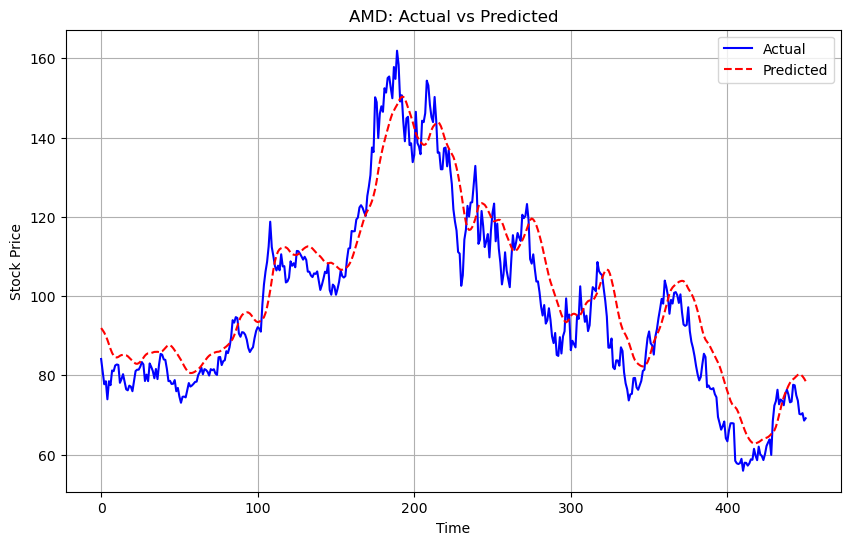

=========For Comcast=========
Epoch 1/50
127/127 [==============================] - 3s 12ms/step - loss: 0.0070 - mse: 0.0140 - val_loss: 7.3627e-04 - val_mse: 0.0015
Epoch 2/50
127/127 [==============================] - 1s 9ms/step - loss: 0.0025 - mse: 0.0050 - val_loss: 6.8471e-04 - val_mse: 0.0014
Epoch 3/50
127/127 [==============================] - 1s 9ms/step - loss: 0.0021 - mse: 0.0042 - val_loss: 0.0017 - val_mse: 0.0035
Epoch 4/50
127/127 [==============================] - 1s 9ms/step - loss: 0.0018 - mse: 0.0037 - val_loss: 5.6931e-04 - val_mse: 0.0011
Epoch 5/50
127/127 [==============================] - 1s 9ms/step - loss: 0.0017 - mse: 0.0034 - val_loss: 5.6311e-04 - val_mse: 0.0011
Epoch 6/50
127/127 [==============================] - 1s 9ms/step - loss: 0.0016 - mse: 0.0031 - val_loss: 9.0301e-04 - val_mse: 0.0018
Epoch 7/50
127/127 [==============================] - 1s 9ms/step - loss: 0.0014 - mse: 0.0028 - val_loss: 0.0019 - val_mse: 0.0037
Epoch 8/50
127/127 [=====

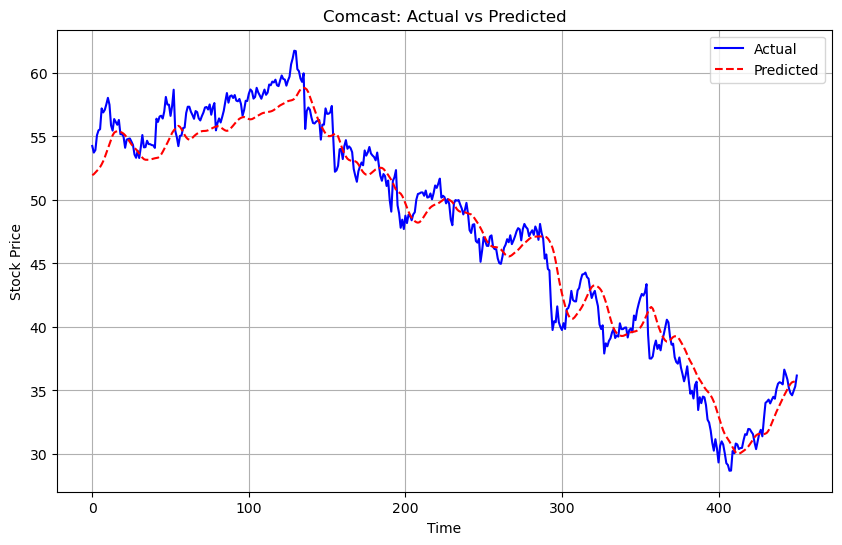

=========For Costco=========
Epoch 1/50
127/127 [==============================] - 3s 12ms/step - loss: 0.0022 - mse: 0.0044 - val_loss: 8.6721e-04 - val_mse: 0.0017
Epoch 2/50
127/127 [==============================] - 1s 9ms/step - loss: 0.0010 - mse: 0.0020 - val_loss: 0.0133 - val_mse: 0.0266
Epoch 3/50
127/127 [==============================] - 1s 9ms/step - loss: 7.0824e-04 - mse: 0.0014 - val_loss: 0.0040 - val_mse: 0.0080
Epoch 4/50
15/15 [==============================] - 0s 3ms/step
The MSE for Costco is 0.0017344102763680051


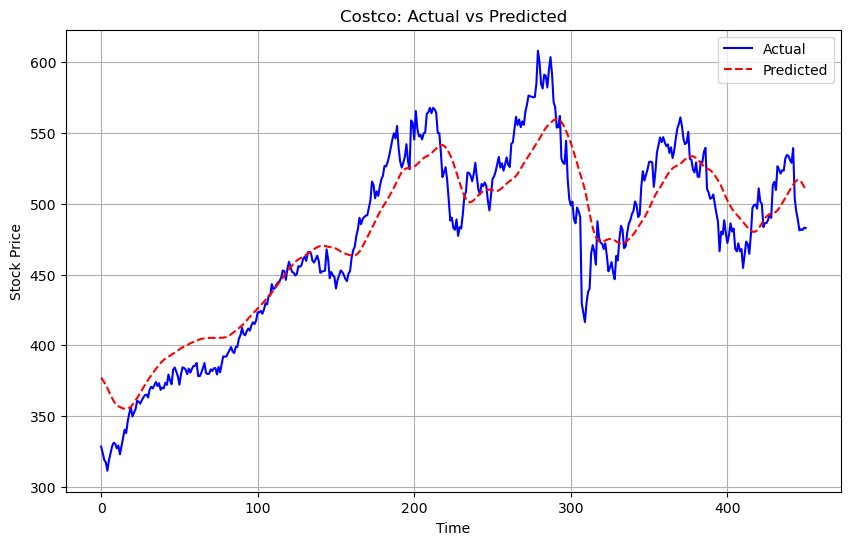

=========For Intel=========
Epoch 1/50
127/127 [==============================] - 4s 13ms/step - loss: 0.0082 - mse: 0.0164 - val_loss: 6.1713e-04 - val_mse: 0.0012
Epoch 2/50
127/127 [==============================] - 1s 10ms/step - loss: 0.0035 - mse: 0.0069 - val_loss: 8.7383e-04 - val_mse: 0.0017
Epoch 3/50
127/127 [==============================] - 1s 11ms/step - loss: 0.0027 - mse: 0.0054 - val_loss: 7.6003e-04 - val_mse: 0.0015
Epoch 4/50
127/127 [==============================] - 1s 10ms/step - loss: 0.0023 - mse: 0.0047 - val_loss: 5.3976e-04 - val_mse: 0.0011
Epoch 5/50
127/127 [==============================] - 1s 11ms/step - loss: 0.0020 - mse: 0.0040 - val_loss: 0.0016 - val_mse: 0.0032
Epoch 6/50
127/127 [==============================] - 1s 11ms/step - loss: 0.0019 - mse: 0.0038 - val_loss: 4.5559e-04 - val_mse: 9.1118e-04
Epoch 7/50
127/127 [==============================] - 1s 10ms/step - loss: 0.0017 - mse: 0.0033 - val_loss: 6.1371e-04 - val_mse: 0.0012
Epoch 8/50
12

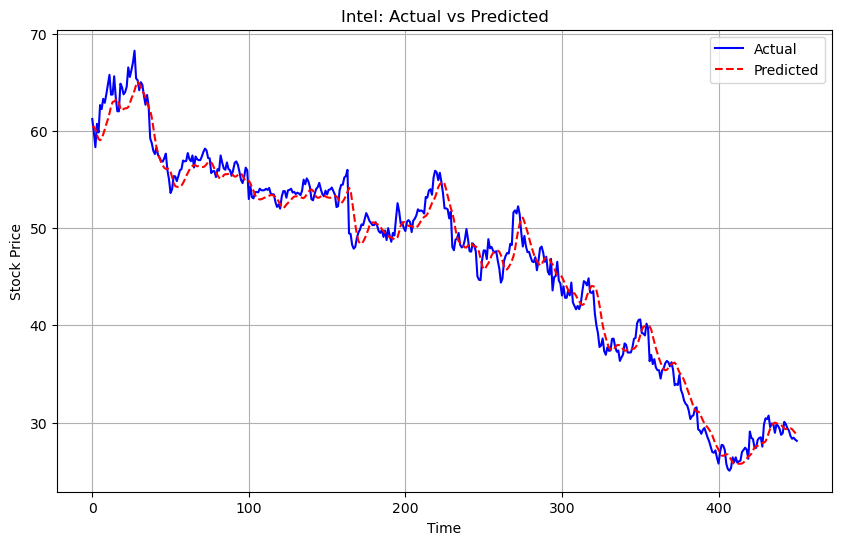

=========For Intuit=========
Epoch 1/50
127/127 [==============================] - 3s 13ms/step - loss: 0.0013 - mse: 0.0025 - val_loss: 0.0025 - val_mse: 0.0050
Epoch 2/50
127/127 [==============================] - 1s 10ms/step - loss: 7.3637e-04 - mse: 0.0015 - val_loss: 0.0025 - val_mse: 0.0049
Epoch 3/50
127/127 [==============================] - 1s 10ms/step - loss: 6.5390e-04 - mse: 0.0013 - val_loss: 0.0010 - val_mse: 0.0020
Epoch 4/50
127/127 [==============================] - 1s 10ms/step - loss: 4.9554e-04 - mse: 9.9108e-04 - val_loss: 9.5648e-04 - val_mse: 0.0019
Epoch 5/50
127/127 [==============================] - 1s 10ms/step - loss: 4.5119e-04 - mse: 9.0237e-04 - val_loss: 0.0056 - val_mse: 0.0111
Epoch 6/50
127/127 [==============================] - 1s 10ms/step - loss: 4.6253e-04 - mse: 9.2507e-04 - val_loss: 0.0034 - val_mse: 0.0067
Epoch 7/50
15/15 [==============================] - 0s 4ms/step
The MSE for Intuit is 0.0019129554774640373


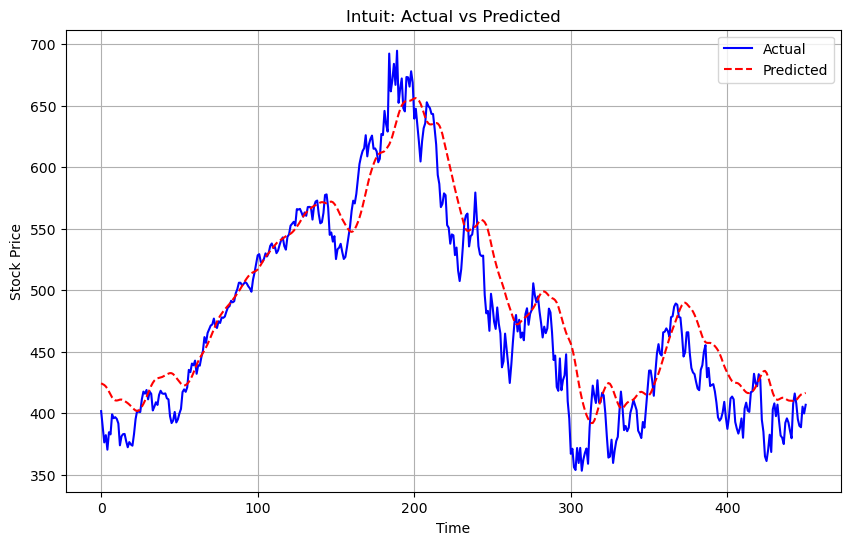

=========For Microsoft=========
Epoch 1/50
127/127 [==============================] - 3s 12ms/step - loss: 0.0023 - mse: 0.0045 - val_loss: 7.8494e-04 - val_mse: 0.0016
Epoch 2/50
127/127 [==============================] - 1s 10ms/step - loss: 0.0010 - mse: 0.0020 - val_loss: 0.0049 - val_mse: 0.0098
Epoch 3/50
127/127 [==============================] - 1s 10ms/step - loss: 8.6735e-04 - mse: 0.0017 - val_loss: 0.0072 - val_mse: 0.0143
Epoch 4/50
15/15 [==============================] - 0s 4ms/step
The MSE for Microsoft is 0.0015698704107578675


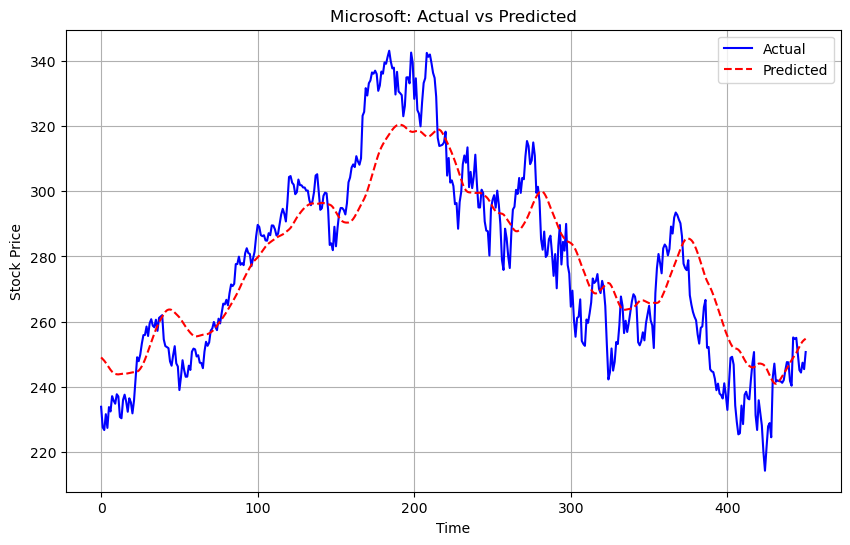

=========For Qualcomm=========
Epoch 1/50
127/127 [==============================] - 3s 12ms/step - loss: 0.0019 - mse: 0.0037 - val_loss: 0.0032 - val_mse: 0.0065
Epoch 2/50
127/127 [==============================] - 1s 9ms/step - loss: 7.9591e-04 - mse: 0.0016 - val_loss: 0.0011 - val_mse: 0.0021
Epoch 3/50
127/127 [==============================] - 1s 9ms/step - loss: 7.9272e-04 - mse: 0.0016 - val_loss: 9.7830e-04 - val_mse: 0.0020
Epoch 4/50
127/127 [==============================] - 1s 9ms/step - loss: 6.7793e-04 - mse: 0.0014 - val_loss: 0.0015 - val_mse: 0.0031
Epoch 5/50
127/127 [==============================] - 1s 9ms/step - loss: 6.2008e-04 - mse: 0.0012 - val_loss: 8.8289e-04 - val_mse: 0.0018
Epoch 6/50
127/127 [==============================] - 1s 9ms/step - loss: 6.0353e-04 - mse: 0.0012 - val_loss: 7.2668e-04 - val_mse: 0.0015
Epoch 7/50
127/127 [==============================] - 1s 9ms/step - loss: 5.4554e-04 - mse: 0.0011 - val_loss: 0.0016 - val_mse: 0.0031
Epoch 8/

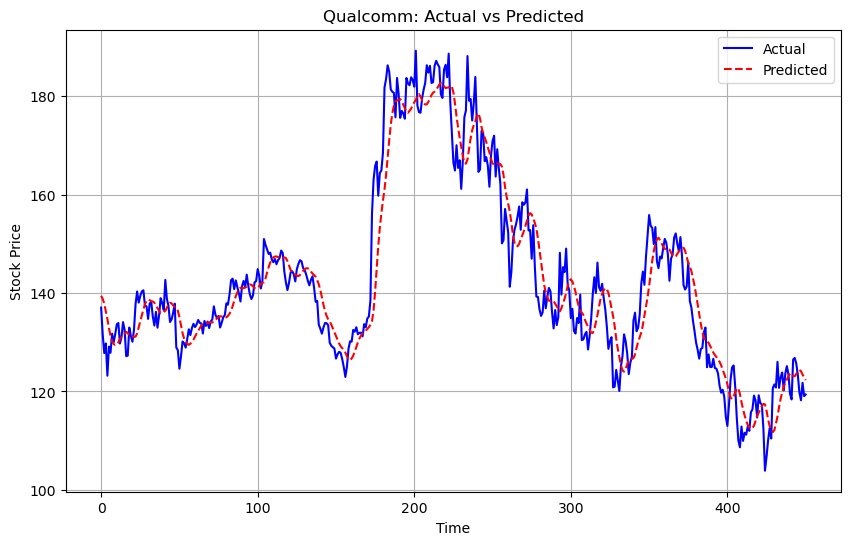

=========For Starbucks=========
Epoch 1/50
127/127 [==============================] - 4s 14ms/step - loss: 0.0064 - mse: 0.0128 - val_loss: 7.0144e-04 - val_mse: 0.0014
Epoch 2/50
127/127 [==============================] - 1s 11ms/step - loss: 0.0023 - mse: 0.0047 - val_loss: 0.0011 - val_mse: 0.0022
Epoch 3/50
127/127 [==============================] - 1s 11ms/step - loss: 0.0019 - mse: 0.0039 - val_loss: 0.0035 - val_mse: 0.0069
Epoch 4/50
15/15 [==============================] - 0s 4ms/step
The MSE for Starbucks is 0.0014028703659340362


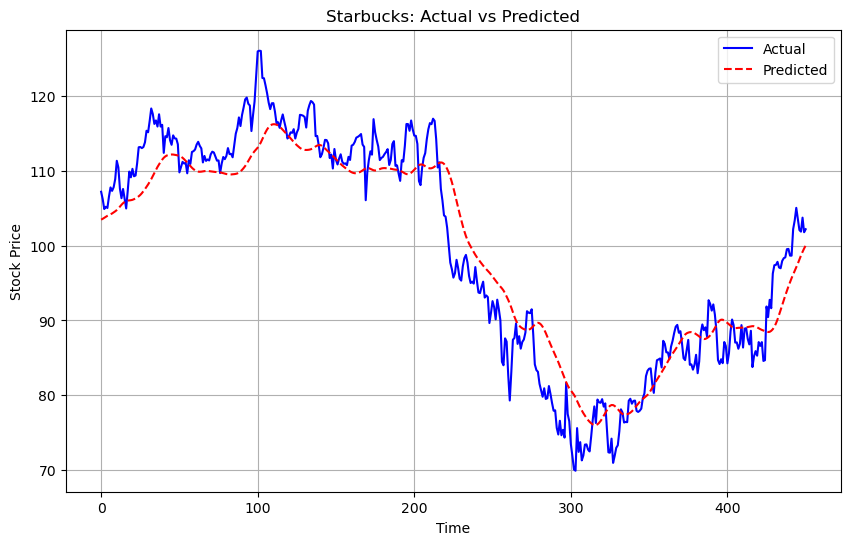


Aggregate MSE for LSTM models across all stocks:  0.0016106967673021068


In [21]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

mse_lstm = 0
mse_results = {}

def plot_predictions_vs_truth(y_test, y_pred, company_name, scaler):
    y_pred = scaler.inverse_transform(y_pred)
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

    plt.figure(figsize=(10, 6))
    plt.plot(y_test, label='Actual', color='blue')
    plt.plot(y_pred, label='Predicted', color='red', linestyle='--')
    plt.title(f'{company_name}: Actual vs Predicted')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.grid(True)
    plt.show()

def predictions_scaled_mse(company, model, X_test, y_test, scaler):
    global mse_lstm 
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    mse_lstm += mse  
    mse_results[company] = mse 
    
    print(f'The MSE for {company} is {mse}')
    plot_predictions_vs_truth(y_test, y_pred, company, scaler)
    
    return y_pred, y_test

scalers = {
    'Apple': aapl_scaler,
    'Adobe': adbe_scaler,
    'AMD': amd_scaler,
    'Comcast': cmcsa_scaler,
    'Costco': cost_scaler,
    'Intel': intc_scaler,
    'Intuit': intu_scaler,
    'Microsoft': msft_scaler,
    'Qualcomm': qcom_scaler,
    'Starbucks': sbux_scaler
}

aapl_model, aapl_predictor, aapl_y_pred = create_and_train_lstm_model(X_train_aapl, y_train_aapl, X_test_aapl, y_test_aapl, 'Apple')
y_pred_aapl, y_test_aapl = predictions_scaled_mse('Apple', aapl_model, X_test_aapl, y_test_aapl, scalers['Apple'])

adbe_model, adbe_predictor, adbe_y_pred = create_and_train_lstm_model(X_train_adbe, y_train_adbe, X_test_adbe, y_test_adbe, 'Adobe')
y_pred_adbe, y_test_adbe = predictions_scaled_mse('Adobe', adbe_model, X_test_adbe, y_test_adbe, scalers['Adobe'])

amd_model, amd_predictor, amd_y_pred = create_and_train_lstm_model(X_train_amd, y_train_amd, X_test_amd, y_test_amd, 'AMD')
y_pred_amd, y_test_amd = predictions_scaled_mse('AMD', amd_model, X_test_amd, y_test_amd, scalers['AMD'])

cmcsa_model, cmcsa_predictor, cmcsa_y_pred = create_and_train_lstm_model(X_train_cmcsa, y_train_cmcsa, X_test_cmcsa, y_test_cmcsa, 'Comcast')
y_pred_cmcsa, y_test_cmcsa = predictions_scaled_mse('Comcast', cmcsa_model, X_test_cmcsa, y_test_cmcsa, scalers['Comcast'])

cost_model, cost_predictor, cost_y_pred = create_and_train_lstm_model(X_train_cost, y_train_cost, X_test_cost, y_test_cost, 'Costco')
y_pred_cost, y_test_cost = predictions_scaled_mse('Costco', cost_model, X_test_cost, y_test_cost, scalers['Costco'])

intc_model, intc_predictor, intc_y_pred = create_and_train_lstm_model(X_train_intc, y_train_intc, X_test_intc, y_test_intc, 'Intel')
y_pred_intc, y_test_intc = predictions_scaled_mse('Intel', intc_model, X_test_intc, y_test_intc, scalers['Intel'])

intu_model, intu_predictor, intu_y_pred = create_and_train_lstm_model(X_train_intu, y_train_intu, X_test_intu, y_test_intu, 'Intuit')
y_pred_intu, y_test_intu = predictions_scaled_mse('Intuit', intu_model, X_test_intu, y_test_intu, scalers['Intuit'])

msft_model, msft_predictor, msft_y_pred = create_and_train_lstm_model(X_train_msft, y_train_msft, X_test_msft, y_test_msft, 'Microsoft')
y_pred_msft, y_test_msft = predictions_scaled_mse('Microsoft', msft_model, X_test_msft, y_test_msft, scalers['Microsoft'])

qcom_model, qcom_predictor, qcom_y_pred = create_and_train_lstm_model(X_train_qcom, y_train_qcom, X_test_qcom, y_test_qcom, 'Qualcomm')
y_pred_qcom, y_test_qcom = predictions_scaled_mse('Qualcomm', qcom_model, X_test_qcom, y_test_qcom, scalers['Qualcomm'])

sbux_model, sbux_predictor, sbux_y_pred = create_and_train_lstm_model(X_train_sbux, y_train_sbux, X_test_sbux, y_test_sbux, 'Starbucks')
y_pred_sbux, y_test_sbux = predictions_scaled_mse('Starbucks', sbux_model, X_test_sbux, y_test_sbux, scalers['Starbucks'])

# Calculate and print the mean MSE across all stocks
mean_mse = mse_lstm / len(mse_results)
print("\nAggregate MSE for LSTM models across all stocks: ", mean_mse)


In [22]:
mse_lstm

0.01610696767302107

In [23]:
mse_results

{'Apple': 0.0015387727473111883,
 'Adobe': 0.00232036536381238,
 'AMD': 0.002473208783325052,
 'Comcast': 0.0009852784927671912,
 'Costco': 0.0017344102763680051,
 'Intel': 0.0007158727677193414,
 'Intuit': 0.0019129554774640373,
 'Microsoft': 0.0015698704107578675,
 'Qualcomm': 0.0014533629875619677,
 'Starbucks': 0.0014028703659340362}

In [24]:
mse_results_lstm=list(mse_results.values())

In [25]:
mse_results_lstm

[0.0015387727473111883,
 0.00232036536381238,
 0.002473208783325052,
 0.0009852784927671912,
 0.0017344102763680051,
 0.0007158727677193414,
 0.0019129554774640373,
 0.0015698704107578675,
 0.0014533629875619677,
 0.0014028703659340362]

In [26]:
import pickle

# Save the mse_results dictionary and mse_lstm value to a file
with open('mse_results_and_lstm.pkl', 'wb') as file:
    pickle.dump({'mse_results_lstm': mse_results_lstm, 'mse_lstm': mse_lstm}, file)

print("mse_results and mse_lstm have been saved to mse_results_and_lstm.pkl")

mse_results and mse_lstm have been saved to mse_results_and_lstm.pkl
